In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms

from bounding_box_classifiers.obama_detector import train_helper

# Reproduce Model

In [5]:
data_dir = "partitioned_data/bounding-box-obama-detector"
# data_dir = "data/obama-detector"

static_params = {
    "seed": 1,
    "data_dir": data_dir,
    "use_cuda": True,
    "val_batch_size": 64,
    "epochs": 10,
    "log_interval": 10
}

best_params = {
    "lr": 0.001,
    "momentum": 0.7,
    "batch_size": 32,
    "use_pretrained": True,
    "feature_extract": True
}

In [6]:
# Reproduce best results
best_params.update(static_params)
best_model_state_dict = train_helper(**best_params)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Train Epoch: 1 [0/248 (0%)]	Loss: 0.692773

Test set: Average loss: 0.6690, Accuracy: 40/64 (62%)

Train Epoch: 2 [0/248 (0%)]	Loss: 0.694347

Test set: Average loss: 0.6630, Accuracy: 39/64 (61%)

Train Epoch: 3 [0/248 (0%)]	Loss: 0.732508

Test set: Average loss: 0.6538, Accuracy: 44/64 (69%)

Train Epoch: 4 [0/248 (0%)]	Loss: 0.709194

Test set: Average loss: 0.6519, Accuracy: 43/64 (67%)

Train Epoch: 5 [0/248 (0%)]	Loss: 0.707319

Test set: Average loss: 0.6558, Accuracy: 42/64 (66%)

Train Epoch: 6 [0/248 (0%)]	Loss: 0.711213

Test set: Average loss: 0.6543, Accuracy: 42/64 (66%)

Train Epoch: 7 [0/248 (0%)]	Loss: 0.610769

Test set: Average loss: 0.6546, Accuracy: 42/64 (66%)

Train Epoch: 8 [0/248 (0%)]	Loss: 0.632134

Test set: Average loss: 0.6506, Accuracy: 43/64 (67%)

Train Epoch: 9 [0/248 (0%)]	Loss: 0.625127

Test set: Average loss: 0.6523, Accuracy: 42/64 (66%)

Train Epoch: 10 [0/248 (0%)]	Loss: 0.637633

Test 

In [7]:
# Load best model weights
device = torch.device("cuda")

best_model = models.vgg11_bn()
num_features = best_model.classifier[6].in_features
best_model.classifier[6] = nn.Linear(num_features, 2)

best_model.load_state_dict(best_model_state_dict)
best_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

# Create visualizations

In [8]:
import sys
sys.path.append('pytorch_cnn_visualizations')

from PIL import Image

from bounding_box_classifiers.obama_detector import data_loaders
from pytorch_cnn_visualizations.vanilla_backprop import VanillaBackprop
from pytorch_cnn_visualizations.guided_backprop import GuidedBackprop
from pytorch_cnn_visualizations.gradcam import GradCam
from pytorch_cnn_visualizations.guided_gradcam import guided_grad_cam
from pytorch_cnn_visualizations.misc_functions import preprocess_image, format_np_output, apply_colormap_on_image

In [9]:
def gradient_images(gradient):
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    
    # Show PIL image
    return Image.fromarray(format_np_output(gradient))

In [10]:
# Load data
train_loader, test_loader = data_loaders(data_dir, use_cuda=True, 
                                         batch_size=1, val_batch_size=1)

dataset = test_loader.dataset
examples = [(i, dataset[i]) for i in range(len(dataset)) if dataset[i][1] == 1]

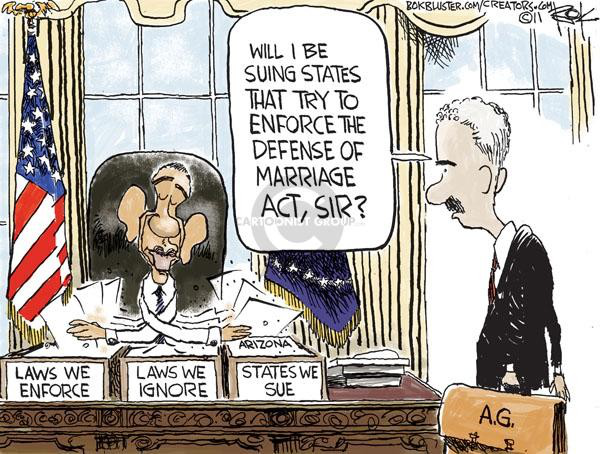

In [11]:
example_num = 30  # 30 is a good one
example_x, example_y = examples[example_num][1]
original_example_num = examples[example_num][0]

example_x = example_x.unsqueeze(dim=0)
example_x = example_x.to(device)
example_x.requires_grad_()

# Display_image
original_x = test_loader.dataset.samples[original_example_num][0]
original_im = Image.open(original_x).convert('RGB')
original_im

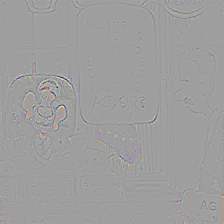

In [12]:
# Guided backprop
GBP = GuidedBackprop(best_model)

# Generate gradients
guided_grads = GBP.generate_gradients(example_x, example_y)
gradient_images(guided_grads)

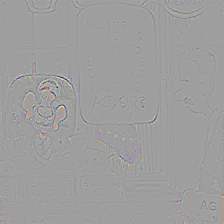

In [13]:
# Vanilla backprop
VBP = VanillaBackprop(best_model)

# Generate gradients
vanilla_grads = VBP.generate_gradients(example_x, example_y)
gradient_images(vanilla_grads)

In [14]:
# Crop original image for GradCAM
crop_image = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224)
])

cropped_original_im = crop_image(original_im)

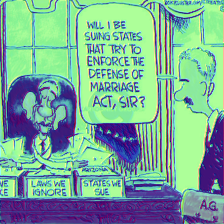

In [15]:
# GradCAM
GC = GradCam(best_model, 0)

# Generate CAM (class activation map)
cam = GC.generate_cam(example_x, example_y)
heatmap, heatmap_on_image = apply_colormap_on_image(cropped_original_im, cam, 'hsv')

heatmap_on_image

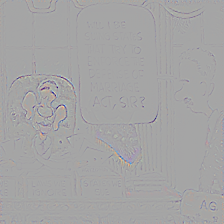

In [16]:
# Guided GradCAM

# Generate guided CAM (class activation map)
cam_gb = guided_grad_cam(cam, guided_grads)
gradient_images(cam_gb)
